In [1]:
from utils import *
from helpers import *
import pandas as pd
from params import *
import os

In [ ]:
# [sum(row) for i, row in enumerate(OD_MATRIX) if i not in FLEX_STOPS]

# hourly_fixed_demand = sum([sum(row) for i, row in enumerate(OD_MATRIX) if i not in FLEX_STOPS])
# hourly_flex_demand = sum([sum(row) for i, row in enumerate(OD_MATRIX) if i in FLEX_STOPS])
# pct_fixed = round(hourly_fixed_demand/(hourly_fixed_demand + hourly_flex_demand)*100, 2)
# pct_flex = round(hourly_flex_demand/(hourly_fixed_demand + hourly_flex_demand)*100, 2)
# print(f'100% demand: {hourly_fixed_demand + hourly_flex_demand}')
# print(f'Fixed demand: {hourly_fixed_demand} ({pct_fixed} %)')
# print(f'Flex demand: {hourly_flex_demand} ({pct_flex} %)')
# get_heatmap(OD_MATRIX, "OD Matrix")

In [ ]:
def plot_minimum_requests_per_delay():
    fig, axs = plt.subplots(figsize=(3, 2))
    delays = np.arange(0, 400, 5)/60
    # plot line of various slopes
    slopes = [0, 0.2, 0.5, 1.0]
    colors = ['red', 'green', 'blue', 'black']
    for slope, color in zip(slopes, colors):
        thresholds = [slope*delay for delay in delays]
        axs.plot(delays, thresholds, color=color, linestyle='dashed', label=f'slope = {slope}')
    axs.set_xlabel('Delay (minutes)')
    axs.set_ylabel('Minimum Requests')
    yticklabels = [0,2,4,6,8,10]
    axs.set_yticks(yticklabels)
    axs.legend()
    axs.grid()

plot_minimum_requests_per_delay()

### all scenarios

In [2]:
def read_results(results_path):
    time_bucket = 30*60
    idle = pd.read_csv(os.path.join(results_path, 'idle.csv'))
    pax = pd.read_csv(os.path.join(results_path, 'pax.csv'))
    pax['bucket'] = pax['arrival_time'] // time_bucket
    state = pd.read_csv(os.path.join(results_path, 'state.csv'))
    trips = pd.read_csv(os.path.join(results_path, 'vehicles.csv'))
    trips['delay'] = trips['arrival_time'] - trips['scheduled_time']
    trips['bucket'] = trips['arrival_time'] // time_bucket
    create_field_from_list_column(state, 3, 'delay')
    create_field_from_list_column(state, 1, 'n_requests')
    create_field_from_list_column(state, 0, 'lost_requests', field_name='unweighted_rewards')
    create_field_from_list_column(state, 1, 'off_schedule_trips', field_name='unweighted_rewards')
    return idle, pax, state, trips


def tabulate_improvements(results_path, on_time_bounds: list, base_scenario: str = 'ND',
                          flex_stops: list = [], start_time: int = 0, 
                          end_time: int = 10000) -> tuple:
    idle, pax, state, trips = read_results(results_path)
    # Filter DataFrames to the specified time range
    idle = idle[(idle['time'] >= start_time) & (idle['time'] <= end_time)]
    pax = pax[(pax['arrival_time'] >= start_time) & (pax['arrival_time'] <= end_time)]
    trips = trips[(trips['arrival_time'] >= start_time) & (trips['arrival_time'] <= end_time)]
    state = state[(state['time'] >= start_time) & (state['time'] <= end_time)]

    # Group and aggregate results for each DataFrame
    n_denied = pax[pax['boarding_time'].isna()].groupby(['scenario']).size()
    idle_sum = (idle.groupby(['scenario'])['idle_time'].sum()/60/60).round(2)
    wait_time_mean = pax.groupby(['scenario'])['wait_time'].mean().round(0)
    fixed_trip_stops = trips[~trips['stop'].isin(flex_stops)]
    headway_cv = (fixed_trip_stops.groupby(['scenario'])['headway'].std() / fixed_trip_stops.groupby(['scenario'])['headway'].mean()).round(3)
    avg_load = trips.groupby(['scenario'])['load'].mean().round(2)
    n_fixed_pax = pax[(~pax['origin'].isin(flex_stops)) & (pax['boarding_time'].notna())].groupby(['scenario']).size()
    n_flex_pax = pax[(pax['origin'].isin(flex_stops)) & (pax['boarding_time'].notna())].groupby(['scenario']).size()
    n_tot_pax = pax[pax['boarding_time'].notna()].groupby(['scenario']).size()
    n_trips = trips[trips['stop']==0].groupby(['scenario']).size()
    on_time_trips = trips[(trips['delay'].between(*on_time_bounds)) & (trips['stop']==0)].groupby(['scenario']).size()
    trips['delay'] = trips['arrival_time'] - trips['scheduled_time']
    average_delay_by_group = trips[~trips['stop'].isin(flex_stops)].groupby('scenario')['delay'].mean().round(0)
    n_deviations = state.groupby(['scenario'])['action'].sum()
    avg_reward = state.groupby(['scenario'])['reward'].mean().round(3)
    avg_episode_reward = state.groupby(['scenario', 'episode'])['reward'].sum()
    avg_episode_reward = avg_episode_reward.groupby('scenario').mean().round(3)

    # Create a DataFrame with all the metrics
    result_df = pd.DataFrame({
        'idle_time': idle_sum,
        'wait_time': wait_time_mean,
        'headway_cv': headway_cv,
        'load': avg_load,
        'n_denied_riders': n_denied,
        'fixed_ridership': n_fixed_pax,
        'flex_ridership': n_flex_pax,
        'tot_ridership': n_tot_pax,
        'n_trips': n_trips,
        'on_time_trips': on_time_trips,
        'avg_delay': average_delay_by_group,
        'n_deviations': n_deviations,
        'avg_reward': avg_reward,
        'avg_episode_reward': avg_episode_reward
    })
    result_df['on_time_rate'] = (result_df['on_time_trips'] / result_df['n_trips'] * 100).round(2)
    result_df['served_rate'] = 100 - result_df['n_denied_riders'] / (result_df['n_denied_riders']+result_df['flex_ridership']) * 100
    result_df['served_rate'] = result_df['served_rate'].fillna(0.0).round(2)
    # Calculate percentage change from the base scenario
    pct_change_df = result_df.copy()
    for col in result_df.columns:
        base_value = result_df.loc[base_scenario, col]
        pct_change_df[col] = ((result_df[col] - base_value) / base_value * 100).round(3)
    
    # Return the result DataFrame
    return result_df, pct_change_df

In [19]:
tstamp = '0305-134112'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
table, table_pcts = tabulate_improvements(RESULTS_PATH, ON_TIME_BOUNDS, base_scenario='DRD_30', 
                                          flex_stops=FLEX_STOPS, start_time=RESULTS_START_TIME_MINUTES*60, 
                                          end_time=RESULTS_END_TIME_MINUTES*60)

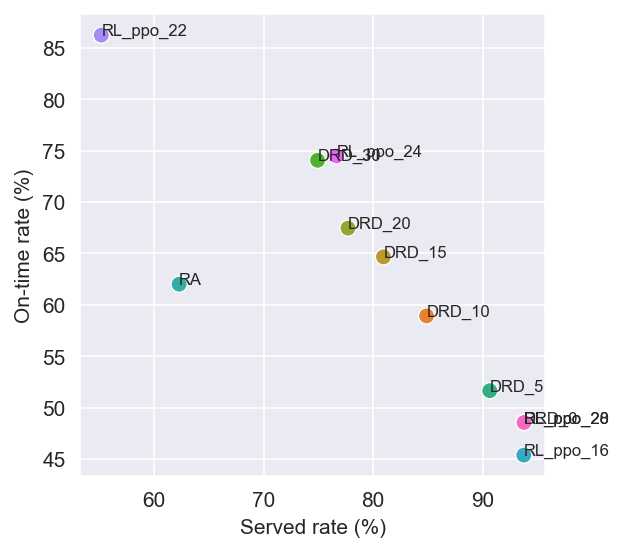

In [20]:
fig, axs = plt.subplots(figsize=(4,4))
## make background of axis dark
sns.set_style("darkgrid")
sns.scatterplot(data=table, x='served_rate', y='on_time_rate', hue='scenario', ax=axs, s=60)
axs.set_xlabel('Served rate (%)')
axs.set_ylabel('On-time rate (%)')
axs.legend().remove()

## add legend labels to dots
for i, txt in enumerate(table.index):
    axs.annotate(txt, (table['served_rate'][i], table['on_time_rate'][i]), fontsize=8)

In [21]:
table[['avg_episode_reward', 'on_time_rate', 'served_rate', 'n_denied_riders', 'flex_ridership', 'tot_ridership']]

,avg_episode_reward,on_time_rate,served_rate,n_denied_riders,flex_ridership,tot_ridership
scenario,,,,,,
DRD_0,-35.44,48.55,93.74,70,1048,5777
DRD_10,-38.48,58.92,84.86,164,919,5731
DRD_15,-38.60,64.66,80.93,208,883,5624
DRD_20,-40.32,67.45,77.70,244,850,5625
DRD_30,-39.16,74.05,74.93,277,828,5617
DRD_5,-37.92,51.64,90.62,102,985,5745
RA,-59.64,62.00,62.31,412,681,5308
RL_ppo_16,-37.44,45.38,93.72,72,1074,5795
RL_ppo_20,-35.44,48.55,93.74,70,1048,5777


In [8]:
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))

In [12]:
state.head(20)

,time,veh_idx,observation,action,reward,unweighted_rewards,scenario,episode
0,760.0,0,"[0, 1, 636.0, -4.0]",1,-4.0,"[3, 1]",RA,0
1,1334.0,1,"[0, 2, 576.0, -28.0]",0,-3.0,"[2, 1]",RA,0
2,1612.0,0,"[3, 2, 748.0, 96.0]",1,-1.0,"[1, 0]",RA,0
3,1913.0,1,"[2, 3, 459.0, -47.0]",0,-6.0,"[5, 1]",RA,0
4,2283.0,0,"[1, 2, 836.0, 171.0]",0,-9.0,"[7, 2]",RA,0
5,2617.0,1,"[1, 1, 336.0, -93.0]",0,-4.0,"[3, 1]",RA,0
6,2876.0,0,"[3, 1, 765.0, 152.0]",1,-1.0,"[1, 0]",RA,0
7,3124.0,1,"[2, 3, 417.0, -26.0]",1,-3.0,"[2, 1]",RA,0
8,3406.0,1,"[0, 1, 874.0, 236.0]",0,0.0,"[0, 0]",RA,0
9,3578.0,0,"[1, 1, 957.0, 264.0]",1,-3.0,"[2, 1]",RA,0


In [ ]:
# idle_for_plot = idle.copy()
# idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
# idle_for_plot['time'] = idle_for_plot['time']/60/60
# plot_cumulative_idle_time(idle_for_plot)

# def plot_avg_reward_per_scenario(rewards_per_scenario: pd.Series, axs):
#     # Sort by average reward
#     rewards_per_scenario = rewards_per_scenario.sort_values(by='scenario')
#     sns.boxplot(x='total_w_reward', y='scenario', data=rewards_per_scenario, ax=axs)

# def get_avg_weighted_rewards(rewards_per_step: pd.DataFrame, weights: list,
#                              reward_fields: list):
#     rewards = rewards_per_step.copy()
#     rewards['total_w_reward'] = 0
#     for i, field in enumerate(reward_fields):
#         rewards['total_w_reward'] -= rewards[field] * weights[i]
#     episode_reward = rewards.groupby(['scenario', 'episode'])['total_w_reward'].sum().reset_index()
#     # episode_reward = episode_reward.groupby(['scenario']).mean()
#     return episode_reward

# def plot_reward_weights_comparison(state: pd.DataFrame, weights_set: list):
#     width_per_ax = 2.7
#     height = 2.3
#     n_weights = len(weights_set)
#     fig, axs = plt.subplots(ncols=n_weights, figsize=(n_weights*width_per_ax, height))
#     reward_fields = ['denied', 'early', 'late']
#     tmp_state = state[['scenario', 'episode'] + reward_fields].copy()
#     for i, weights in enumerate(weights_set):
#         tmp_rew = get_avg_weighted_rewards(tmp_state, weights, reward_fields)
#         if n_weights > 1:
#             plot_avg_reward_per_scenario(tmp_rew, axs[i])
#             axs[i].set_title(f'Weights: {weights}')
#         else:
#             plot_avg_reward_per_scenario(tmp_rew, axs)
#             axs.set_title(f'Weights: {weights}')

# weights = [[1.0,1.0,1.0], [1.0,1.0,2.0], [1.0,2.5,2.5], [1.0,1.0,2.5]]
# plot_reward_weights_comparison(state, weights)

## debugging

In [1]:
from objects import RouteManager, EventManager

route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

obs, reward, terminated, truncated, info = event.step(route, action=None)
# while not terminated:
#     obs, reward, terminated, truncated, info = event.step(route, action=True)

In [ ]:
event.timestamps[-1]

In [ ]:
pax.groupby(['origin', 'destination']).size().reset_index()

In [ ]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])